# <b>Поиск по изображениям</b>

# Описание проекта

Вы работаете в фотохостинге для профессиональных фотографов _«Со Смыслом»_ (_“With Sense”_). 
Ваши пользователи размещают свои фотографии на хостинге и сопровождают их полным описанием: указывают место съёмок, модель камеры и т. д. Отличительная особенность сервиса — описание: его может предоставить не только тот, кто размещает фотографию, но и другие пользователи портала. 

Ваш отдел занимается экспериментом по разработке поиска референсных фотографий для фотографов. Суть поиска заключается в следующем: пользователь сервиса вводит описание нужной сцены. Например, такое:

    A man is crossing a mountain pass on a metal bridge.

Сервис выводит несколько фотографий с такой же или похожей сценой.

Чтобы эксперимент получил право на жизнь, нужно защитить его перед руководителем компании. Для защиты необходимо презентовать так называемый PoC (_Proof of Concept_, _Проверка концепции_) — продемонстрировать, что такой проект практически осуществим. Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно выбрать лучшую  модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от `0` до `1` — и покажет, насколько текст и картинка подходят друг другу. 

На основе лучшей модели можно будет собрать предварительную версию продукта, которую вы покажете руководителю компании.

## Юридические ограничения

В некоторых странах, где работает компания _With Sense_, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно, текстов, изображений, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16-ти лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

    This image is unavailable in your country in compliance with local laws.

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому необходимо очистить данные от проблемного контента. Во время тестирования модели при появлении в запросе “вредного” контента должен отображаться дисклеймер.

## Описание данных

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до `5` описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

- Имя файла изображения;
- Идентификатор описания;
- Доля людей, подтвердивших, что описание соответствует изображению;
- Количество человек, подтвердивших, что описание соответствует изображению;
- Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` — данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

- Имя файла изображения;
- Идентификатор описания;
- `3`, `4`, `5` — оценки трёх экспертов.

Эксперты ставят оценки по шкале от `1` до `4`, где:

- `1` — изображение и запрос совершенно не соответствуют друг другу,
- `2` — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует,
- `3` — запрос и текст соответствуют с точностью до некоторых деталей,
- `4` — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до `5` описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.



# Инструкция по выполнению проекта

## Шаг 1. Загрузите данные и проведите исследовательский анализ данных

### Шаг 1.1 Скачайте  и откройте файлы с данными

Датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи нужно агрегировать эти оценки — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае `2` или `3`), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: `1`, `4`, `2`. В таком случае данную пару изображение-текст можно исключить из датасета.

Можно воспользоваться другим методом агрегации оценок.

В файле с краудсорсинговыми оценками информация расположена в таком порядке: 

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке. 
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

Устанавливаем нужные библиотеки, если они вдруг отсутствуют:

In [ ]:
%pip install pandas==1.5.3 numpy==1.22.4 matplotlib==3.7.1 seaborn==0.12.2 scikit-learn==1.2.2 tqdm==4.65.0
%pip install torch==2.0.0+cu118 torchvision==0.15.1+cu118 torchmetrics==0.11.4
%pip install transformers[torch]==4.27.4
%pip install Pillow==8.4.0
%pip install lightgbm==3.3.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 8.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 45.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 72.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 22.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Скачиваем и распаковываем нужные файлы:

In [ ]:
!rm -rf dsplus_integrated_project_4.zip
!rm -rf __MACOSX
!rm -rf to_upload
!rm -rf bert_config.json
!rm -rf rubert_model.bin
!rm -rf vocab.txt

In [ ]:
!wget --quiet ...
!unzip -q dsplus_integrated_project_4.zip

Импортируем необходимые модули:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from sklearn.model_selection import GroupShuffleSplit, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, SGDRegressor
from sklearn.metrics import mean_absolute_error, roc_auc_score, mean_absolute_error, mean_squared_error
from sklearn.base import BaseEstimator
from sklearn.pipeline import Pipeline
import lightgbm as lgb
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
from torch.utils.data import Dataset, DataLoader
from torchmetrics import MeanAbsoluteError
import transformers
from transformers import BertTokenizer, BertModel

import torchvision
from PIL import Image

import json
import math
import os
from pathlib import Path
import random
from tqdm import notebook
from tqdm.notebook import trange

device = torch.device('cuda')

Загружаем тренировочные данные и данные по соответствию изображения и текстового описания (экспертные и краудсорсинговые):

In [ ]:
data_dir = '...'

train_df = pd.read_csv(f'{data_dir}/train_dataset.csv')
crowd_annot_df = pd.read_csv(f'{data_dir}/CrowdAnnotations.tsv', header=None, sep='\t')
expert_annot_df = pd.read_csv(f'{data_dir}/ExpertAnnotations.tsv', header=None, sep='\t')

crowd_annot_df = crowd_annot_df.rename(columns={
    0: 'image', 1: 'query_id', 2: 'portion', 3: 'num_voted_relevant', 4: 'num_voted_irrelevant'})

expert_annot_df = expert_annot_df.rename(columns={
    0: 'image', 1: 'query_id', 2: 'expert_1', 3: 'expert_2', 4: 'expert_3'})

print('train_df:')
display(train_df.head())
print('crowd_annot_df:')
display(crowd_annot_df.head())
print('expert_annot_df:')
display(expert_annot_df.head())

print(f'train_df.shape={train_df.shape}')
print(f'crowd_annot_df.shape={crowd_annot_df.shape}')
print(f'expert_annot_df.shape={expert_annot_df.shape}')

train_df:


image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...  
3  A young child is wearing blue goggles and sitt...  
4  A young child is wearing blue goggles and sitt...

crowd_annot_df:


image                     query_id  portion  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2      1.0   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2      0.0   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2      0.0   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2      0.0   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2      0.0   

   num_voted_relevant  num_voted_irrelevant  
0                   3                     0  
1                   0                     3  
2                   0                     3  
3                   0                     3  
4                   0                     3

expert_annot_df:


image                     query_id  expert_1  expert_2  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2         1         1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2         1         1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2         1         1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2         1         2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2         1         1   

   expert_3  
0         1  
1         2  
2         2  
3         2  
4         2

train_df.shape=(5822, 3)
crowd_annot_df.shape=(47830, 5)
expert_annot_df.shape=(5822, 5)


Сливаем вместе таблицы все три наши таблицы через `OUTER-JOIN`:

In [ ]:
train_data_merged = train_df.merge(expert_annot_df, on=['image', 'query_id'], how='outer')
train_data_merged = train_data_merged.merge(crowd_annot_df, on=['image', 'query_id'], how='outer')

sample_indices = [21867, 38665, 9445, 505, 48000]

display(train_data_merged.loc[sample_indices])
print(f'train_data_merged.shape={train_data_merged.shape}')

image                     query_id  \
21867  2704934519_457dc38986.jpg   539751252_2bd88c456b.jpg#2   
38665  3467219837_7d62213dec.jpg  3028969146_26929ae0e8.jpg#2   
9445   1584315962_5b0b45d02d.jpg  3316725440_9ccd9b5417.jpg#2   
505    2215136723_960edfea49.jpg  2100816230_ff866fb352.jpg#2   
48000   497791037_93499238d8.jpg  2905942129_2b4bf59bc0.jpg#2   

                            query_text  expert_1  expert_2  expert_3  portion  \
21867                              NaN       NaN       NaN       NaN      0.0   
38665                              NaN       NaN       NaN       NaN      0.0   
9445                               NaN       NaN       NaN       NaN      0.0   
505    A man jumps while snow skiing .       1.0       2.0       3.0      0.0   
48000                              NaN       NaN       NaN       NaN      0.0   

       num_voted_relevant  num_voted_irrelevant  
21867                 0.0                   3.0  
38665                 0.0                   3.0  
9445                  0.0                   3.0  
505                   0.0                   3.0  
48000                 0.0                   3.0

train_data_merged.shape=(51323, 9)


Видим, что данных стало гораздо больше - `51323` строк, но в поле `query_text` есть пропуски. Пробуем их заполнить, исходя из того, что для пропущенных значений могут встретиться такие строки, где для аналогичного `query_id` будет выставлен непустой `query_text`, который мы сможем заимствовать для заполнения пропуска:

In [ ]:
query_id_to_query_text = dict()

def collect_query_id_to_query_text(row):
    if not pd.isnull(row['query_text']):
        query_id_to_query_text[row['query_id']] = row['query_text']
        
_ = train_data_merged.apply(collect_query_id_to_query_text, axis=1)

def fill_nans(row):
    if pd.isnull(row['query_text']) and row['query_id'] in query_id_to_query_text:
        row['query_text'] = query_id_to_query_text[row['query_id']]
    return row
    
train_data_merged = train_data_merged.apply(fill_nans, axis=1)
train_data_merged = train_data_merged.dropna(subset=['query_text'])

display(train_data_merged.loc[sample_indices])
print(f'train_data_merged.shape={train_data_merged.shape}')

image                     query_id  \
21867  2704934519_457dc38986.jpg   539751252_2bd88c456b.jpg#2   
38665  3467219837_7d62213dec.jpg  3028969146_26929ae0e8.jpg#2   
9445   1584315962_5b0b45d02d.jpg  3316725440_9ccd9b5417.jpg#2   
505    2215136723_960edfea49.jpg  2100816230_ff866fb352.jpg#2   
48000   497791037_93499238d8.jpg  2905942129_2b4bf59bc0.jpg#2   

                                              query_text  expert_1  expert_2  \
21867  Child in blue trunks splashing in blue kiddie ...       NaN       NaN   
38665  A golden retriever running on short grass wear...       NaN       NaN   
9445               A man rides a bike through a course .       NaN       NaN   
505                      A man jumps while snow skiing .       1.0       2.0   
48000    The two children swinging together on a swing .       NaN       NaN   

       expert_3  portion  num_voted_relevant  num_voted_irrelevant  
21867       NaN      0.0                 0.0                   3.0  
38665       NaN      0.0                 0.0                   3.0  
9445        NaN      0.0                 0.0                   3.0  
505         3.0      0.0                 0.0                   3.0  
48000       NaN      0.0                 0.0                   3.0

train_data_merged.shape=(50214, 9)


Видим, что все `4` случайных пропуска, обнаруженные ранее, были заполнены.

Теперь попробуем использовать тот факт, что значения поля `query_id` по сути представляют собой пару, где явно указан идентификатор изображения, которое точно релевантно описанию по данному идентификатору. Воспользуемся этим, распарсив значения этих полей `query_id` и сформируем такое дополнительный поднабор данных из точно релевантных пар:

In [ ]:
matched_pairs = train_data_merged[['query_id', 'query_text']].copy().drop_duplicates()

matched_pairs = matched_pairs.assign(
  image = lambda x: x['query_id'].str[0:-2],
  target_prob = 1.0
).reindex(columns=['image', 'query_id', 'query_text', 'target_prob'])

display(matched_pairs.head())
print(f'matched_pairs.shape={matched_pairs.shape}')

image                     query_id  \
0   2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
12  2718495608_d8533e3ac5.jpg  2718495608_d8533e3ac5.jpg#2   
22  3181701312_70a379ab6e.jpg  3181701312_70a379ab6e.jpg#2   
27  3207358897_bfa61fa3c6.jpg  3207358897_bfa61fa3c6.jpg#2   
31  3286822339_5535af6b93.jpg  3286822339_5535af6b93.jpg#2   

                                           query_text  target_prob  
0   A young child is wearing blue goggles and sitt...          1.0  
12  A girl wearing a yellow shirt and sunglasses s...          1.0  
22    A man sleeps under a blanket on a city street .          1.0  
27  A woman plays with long red ribbons in an empt...          1.0  
31         Chinese market street in the winter time .          1.0

matched_pairs.shape=(977, 4)


Получили поднабор из `977` релевантных пар изображение+тектовое описание.

Теперь сольём этот поднабор с нашим основным набором, формируя итоговый тренировочный набор:

In [ ]:
train_data = train_data_merged.merge(matched_pairs, on=['image', 'query_id', 'query_text'], how='outer')

display(train_data.head())
display(train_data.tail())
print(f'train_data.shape={train_data.shape}')

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  expert_1  expert_2  \
0  A young child is wearing blue goggles and sitt...       1.0       1.0   
1  A young child is wearing blue goggles and sitt...       1.0       1.0   
2  A young child is wearing blue goggles and sitt...       1.0       2.0   
3  A young child is wearing blue goggles and sitt...       4.0       4.0   
4  A young child is wearing blue goggles and sitt...       1.0       1.0   

   expert_3  portion  num_voted_relevant  num_voted_irrelevant  target_prob  
0       1.0      0.0                 0.0                   3.0          NaN  
1       1.0      NaN                 NaN                   NaN          NaN  
2       2.0      0.0                 0.0                   3.0          NaN  
3       4.0      1.0                 3.0                   0.0          1.0  
4       1.0      NaN                 NaN                   NaN          NaN

image                     query_id  \
50475  1082379191_ec1e53f996.jpg  1082379191_ec1e53f996.jpg#2   
50476   410453140_5401bf659a.jpg   410453140_5401bf659a.jpg#2   
50477  3200120942_59cfbb3437.jpg  3200120942_59cfbb3437.jpg#2   
50478  2475162978_2c51048dca.jpg  2475162978_2c51048dca.jpg#2   
50479  2061144717_5b3a1864f0.jpg  2061144717_5b3a1864f0.jpg#2   

                                              query_text  expert_1  expert_2  \
50475              A man and a woman sitting on a dock .       NaN       NaN   
50476  A man stands at the entrance of Yerba Buena Ce...       NaN       NaN   
50477  One person is on a ski lift while another snow...       NaN       NaN   
50478  a woman holding a small ball chasing after a s...       NaN       NaN   
50479         A man in an ampitheater talking to a boy .       NaN       NaN   

       expert_3  portion  num_voted_relevant  num_voted_irrelevant  \
50475       NaN      NaN                 NaN                   NaN   
50476       NaN      NaN                 NaN                   NaN   
50477       NaN      NaN                 NaN                   NaN   
50478       NaN      NaN                 NaN                   NaN   
50479       NaN      NaN                 NaN                   NaN   

       target_prob  
50475          1.0  
50476          1.0  
50477          1.0  
50478          1.0  
50479          1.0

train_data.shape=(50480, 10)


Видим, что данных по-прежнему больше `50000`.

~~Видим, что после INNER-слияния число строк в полученной таблице осталось прежним, значит, в этих двух таблицах действительно были одни и те же значения  по полям `image` и `query_id`.~~

~~Теперь мы можем выполнить слияние и третьей таблицы - с краудсорсинговыми разметками. Если мы снова выполним INNER-слияние, то окажется, что оценок в итоговой таблице будет почти в `2` раза меньше - `2329`, так что мы потеряем почти половину тренировочного набора. В то же время, нас могли бы устроить и данные без краудсорсинговых оценок, ведь у нас есть оценки экспертов (что внушает доверие), тем более трёх.~~

~~Поэтому выполним LEFT-слияние, чтобы не потерять ни одного из имеющихся у нас `5822` тренировочных экземпляра:~~

In [ ]:
#display(train_data.shape)
#display(train_data.head())

~~Видим, что в выдаче появились `NaN`-ы, которые как раз и соответствуют тем парам из имени файла изображения из идентификатора описания, которых не оказалось среди краудсорсинговых данных. Заполнять их чем-либо, сигнализирующим о том, что данные значения нельзя использовать, или нет, решим позднее.~~

### Шаг 1.2 Проверьте данные и откорректируйте их, если потребуется

Начнём последовательно проверять и исследовать данные, содержащиеся в полученной таблице.

### Поле `image`

Сначала проверим, что все файлы, которые указаны в столбце `image`, действительно существуют:

In [ ]:
_ = train_data['image'].apply(lambda p: Path(f'{data_dir}/train_images/{p}').is_file() or print(f'File "{p}" was not found!'))

Видим, что все файлы существуют. Посколько в папке `train_images` ровно `1000` файлов, то столько же должно быть и уникальных значений в столбце `image`:

In [ ]:
print(f"Уникальных значений в поле 'image': {train_data['image'].unique().shape[0]}")

Уникальных значений в поле 'image': 1000


### Поле `query_id`

Посмотрим на распределения частот использования каждого из текстовых описаний.

In [ ]:
query_id_dist = train_data['query_id'].value_counts()
display(query_id_dist.to_frame())

query_id
249394748_2e4acfbbb5.jpg#2        176
820169182_f5e78d7d19.jpg#2        152
500446858_125702b296.jpg#2        152
2869491449_1041485a6b.jpg#2       145
2860872588_f2c7b30e1a.jpg#2       141
...                               ...
3592968286_b63c81bcd2.jpg#2        14
3191135894_2b4bdabb6d.jpg#2        12
3042380610_c5ea61eef8.jpg#2        11
3584561689_b6eb24dd70.jpg#2        10
1547883892_e29b3db42e.jpg#2        10

[977 rows x 1 columns]

На первый взгляд, частоты выглядят совсем неравномерно: описание с идентификатором `249394748_2e4acfbbb5.jpg#2` использовалось аж `176` раз, в то время как есть описания, использовавшиеся лишь десять раз.

Попробуем посмотреть на распределение графически:

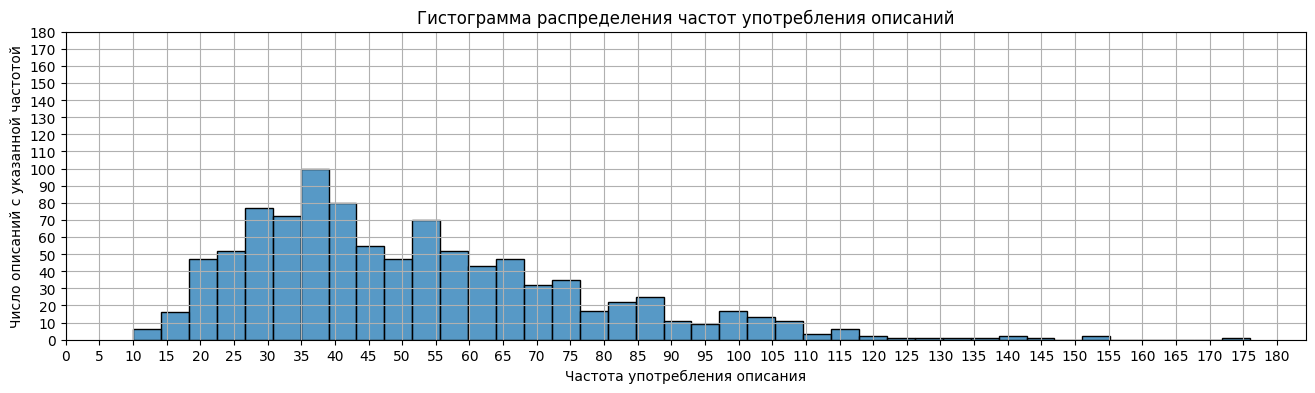

In [ ]:
fig, ax = plt.subplots(figsize=(16, 4))
_ = sns.histplot(data=query_id_dist.values, bins=40, ax=ax)
_ = ax.set_xlabel('Частота употребления описания')
_ = ax.set_ylabel('Число описаний с указанной частотой')
_ = ax.set_title('Гистограмма распределения частот употребления описаний')
_ = ax.set_xticks(range(0, 185, 5))
_ = ax.set_yticks(range(0, 185, 10))
_ = ax.grid(True)

Видим, что мода распределения около на частоте около `35`-`40`, а значения больше `120` встречаются крайне редко, и их можно было бы расценивать как выбросы.

### Поле `query_text`

Попробуем узнать что-то о длинах описаний (в токенах):

In [ ]:
train_data['query_length'] = train_data['query_text'].apply(lambda r: len(r.split()))
display(train_data['query_length'].sort_values(ascending=False))

16205    34
2159     34
32376    34
40178    34
10053    34
         ..
32521     2
24778     2
34482     2
32327     2
23503     2
Name: query_length, Length: 50480, dtype: int64

Видим несколько комментариев длиной в `2` токена.

Посмотрим на `5` случайных из них:

In [ ]:
display(train_data.query('query_length == 2').sample(5))

image                     query_id     query_text  \
34482  3328646934_5cca4cebce.jpg  3108732084_565b423162.jpg#2  a snowboarder   
37043  3433982387_3fa993cf5a.jpg  3125309108_1011486589.jpg#2    rugby match   
5582   3544793763_b38546a5e8.jpg  3125309108_1011486589.jpg#2    rugby match   
5580   3498327617_d2e3db3ee3.jpg  3125309108_1011486589.jpg#2    rugby match   
29251  3125309108_1011486589.jpg  3125309108_1011486589.jpg#2    rugby match   

       expert_1  expert_2  expert_3  portion  num_voted_relevant  \
34482       NaN       NaN       NaN      0.0                 0.0   
37043       NaN       NaN       NaN      0.0                 0.0   
5582        1.0       2.0       2.0      0.0                 0.0   
5580        1.0       1.0       1.0      NaN                 NaN   
29251       NaN       NaN       NaN      1.0                 3.0   

       num_voted_irrelevant  target_prob  query_length  
34482                   3.0          NaN             2  
37043                   3.0          NaN             2  
5582                    3.0          NaN             2  
5580                    NaN          NaN             2  
29251                   0.0          1.0             2

Судя по всему, даже эти наиболее короткие описания всё же корректны.

Наконец, посмотрим на гистограмму распределения длин описаний:

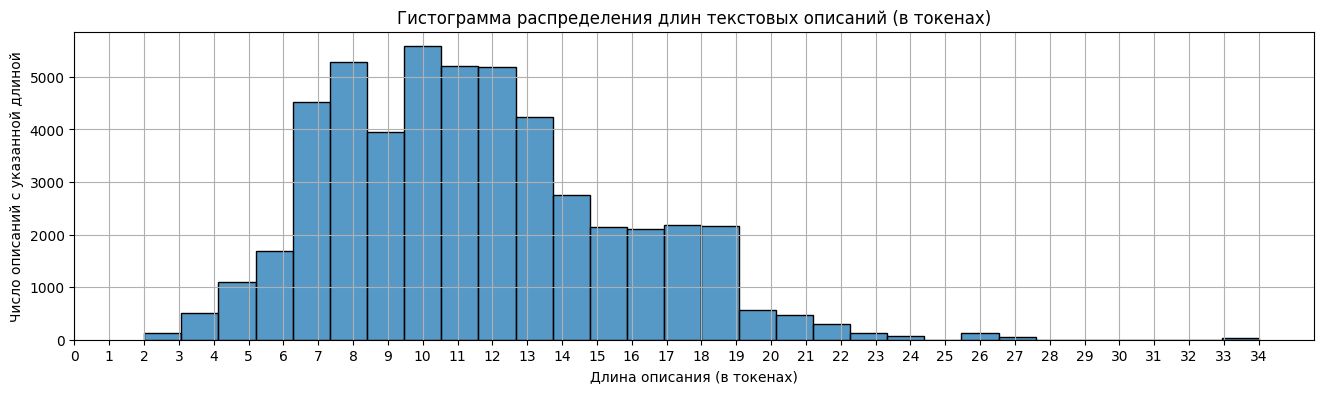

In [ ]:
fig, ax = plt.subplots(figsize=(16, 4))
_ = sns.histplot(data=train_data['query_length'], bins=30, ax=ax)
_ = ax.set_xlabel('Длина описания (в токенах)')
_ = ax.set_ylabel('Число описаний с указанной длиной')
_ = ax.set_title('Гистограмма распределения длин текстовых описаний (в токенах)')
_ = ax.set_xticks(range(0, 35))
_ = ax.grid(True)

Распределение чем-то отдалённо напоминающее нормальное, с модой где-то около `12` токенов и чуть более длинным правым хвостом.

Поле с длинами описаний нам больше не потребуется, поэтому удалим его:

In [ ]:
train_data.drop('query_length', axis=1, inplace=True)
display(train_data.head())

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  expert_1  expert_2  \
0  A young child is wearing blue goggles and sitt...       1.0       1.0   
1  A young child is wearing blue goggles and sitt...       1.0       1.0   
2  A young child is wearing blue goggles and sitt...       1.0       2.0   
3  A young child is wearing blue goggles and sitt...       4.0       4.0   
4  A young child is wearing blue goggles and sitt...       1.0       1.0   

   expert_3  portion  num_voted_relevant  num_voted_irrelevant  target_prob  
0       1.0      0.0                 0.0                   3.0          NaN  
1       1.0      NaN                 NaN                   NaN          NaN  
2       2.0      0.0                 0.0                   3.0          NaN  
3       4.0      1.0                 3.0                   0.0          1.0  
4       1.0      NaN                 NaN                   NaN          NaN

### Поля `expert_1`, `expert_2`, `expert_3`

Теперь узнаем больше про содержимое оценок экспертов. Начнём с самих значений - действительно ли они укладываются в отрезок от `1` до `4`:

expert_1  expert_2  expert_3
1.0      4120      3327      2350
2.0      1109      1666      2222
3.0       346       518       837
4.0       247       311       413

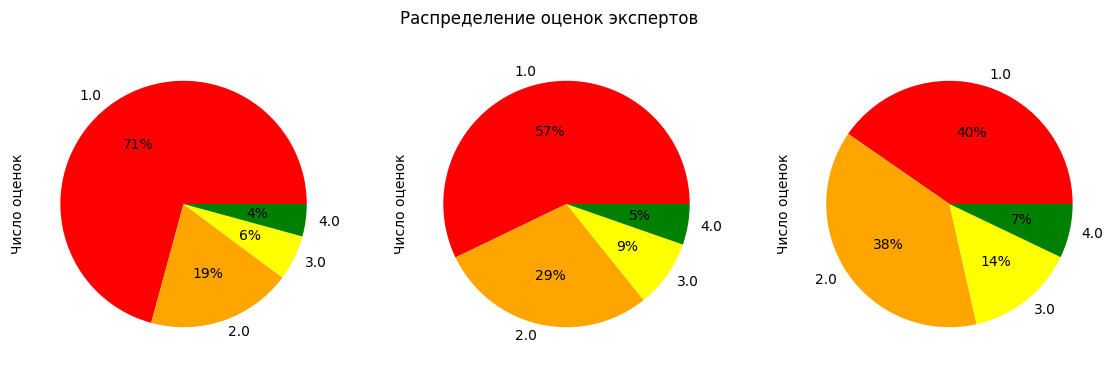

In [ ]:
experts_dist = pd.DataFrame({'expert_1': train_data['expert_1'].value_counts(),
  'expert_2': train_data['expert_2'].value_counts(),
  'expert_3': train_data['expert_3'].value_counts()})

display(experts_dist)

def plot_experts_marks_chart(expert_id, ax):
  _ = train_data[expert_id].value_counts().plot.pie(autopct='%1.0f%%',
    colors = ['red', 'orange', 'yellow', 'green'],
    ax=ax);
  _ = ax.set_ylabel('Число оценок')

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
plot_experts_marks_chart('expert_1', ax1)
plot_experts_marks_chart('expert_2', ax2)
plot_experts_marks_chart('expert_3', ax3)
_ = fig.suptitle('Распределение оценок экспертов')

Видим, что тут нет никаких выбросов, все оценки действительно от `1` до `4`. Первый эксперт выглядит самым строгим - у него наибольшее количество оценок в `1` балл (совершенно не соответствуют), и минимальное количество оценок в `4` балла (полное соответствие).

Второй эксперт, судя по всему, был не так категоричен в своих оценках несоответствия: количество оценок в `1` балл у него значительно меньше, чем у первого эксперта, но существенно выше количество оценок в `2` балла.

Третий эксперт интересен почти равными долями для оценок в `1` и `2` балла. У него же и является наибольшей сумма долей из `3` и `4` - этот эксперт выглядит как наиболее мягкий и допускающий некоторое расхождение между изображением и описанием в своих оценках.

### Поле `portion`

Данное поле должно соответствовать понятию о доле, т.е. быть вещественным числом от `0` до `1`, проверим это.


portion
0.00    40932
0.33     2962
0.67     1348
1.00     1305
0.25       94
0.50       27
0.20       22
0.75        9
0.40        8
0.60        7
0.80        4
0.17        3

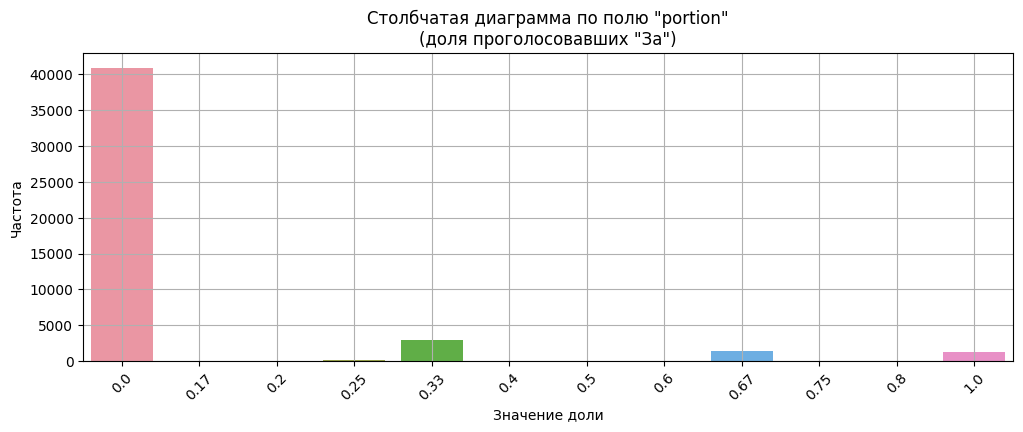

In [ ]:
portion_dist = train_data['portion'].value_counts()
portion_dist.rename(index={k: round(k, 2) for k in portion_dist.index}, inplace=True)
display(portion_dist.to_frame())

fig, ax = plt.subplots(figsize=(12, 4))
_ = sns.barplot(x=portion_dist.index, y=portion_dist, ax=ax)
_ = ax.tick_params(axis='x', rotation=45)
_ = ax.grid(True)
_ = ax.set_title('Столбчатая диаграмма по полю "portion"\n(доля проголосовавших "За")')
_ = ax.set_xlabel('Значение доли')
_ = ax.set_ylabel('Частота')

Явный пик в `0.0` - когда никто из разметивших не подтвердил соответствие изображнния и описания. Также заметно примерно равные доли у значений `0.33`, `0.67` и `1.0`. Причём сравнительная высокая частотность значений `0.33` (треть) и `0.67` (две трети) может говорить о том, что среди голосовавших было `3` участников. Но есть и другие значения, которые говорят о том, что краудсорсинговых разметчиков не всегда было `3`.

Посмотрим, какое количество краудсорсинговых разметчиков было привлечено для каждой из оценочных пар:

In [ ]:
crowd_annotators_cnt = train_data['num_voted_relevant'] + train_data['num_voted_irrelevant']

def print_value_counts(series):
  value_counts = series.value_counts().sort_index().to_frame()
  value_counts = (value_counts.rename(index={k: int(k) for k in value_counts.index})
                              .rename(columns={'count': 'crowd-sources annotators count'}))
  display(value_counts)

print('Суммарное количество краудсорсинговых аннотаторов:')
print_value_counts(crowd_annotators_cnt)

Суммарное количество краудсорсинговых аннотаторов:


0
3  45699
4    763
5    209
6     50

Видим, что хоть и крайне редко, но иногда разметчиков было и `4`, и `5` и `6`, что и объясняет появление долей вроде `0.2` и прочих.

### Поля `num_voted_relevant` и `num_voted_irrelevant`

Суммарное количество краудсорсинговых аннотаторов, прогосоловавших "За":


num_voted_relevant
0               40932
1                3079
2                1382
3                1309
4                  14
5                   5

Суммарное количество краудсорсинговых аннотаторов, прогосоловавших "Против":


num_voted_irrelevant
0                  1305
1                  1359
2                  2995
3                 40204
4                   650
5                   166
6                    42

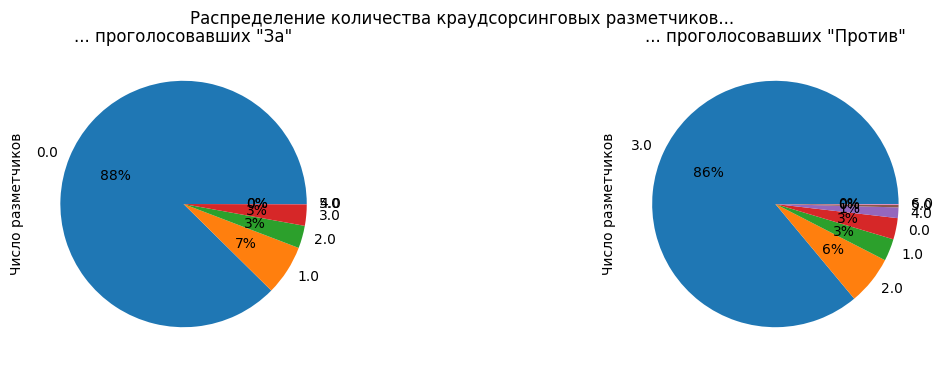

In [ ]:
print('Суммарное количество краудсорсинговых аннотаторов, прогосоловавших "За":')
print_value_counts(train_data['num_voted_relevant'])

print('Суммарное количество краудсорсинговых аннотаторов, прогосоловавших "Против":')
print_value_counts(train_data['num_voted_irrelevant'])

def plot_crowdsourced_mark_chart(series, title, ax):
  _ = series.value_counts().plot.pie(autopct='%1.0f%%', ax=ax);
  _ = ax.set_ylabel('Число разметчиков')
  _ = ax.set_title(title)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
plot_crowdsourced_mark_chart(train_data['num_voted_relevant'],
                             '... проголосовавших "За"',ax1)
plot_crowdsourced_mark_chart(train_data['num_voted_irrelevant'],
                             '... проголосовавших "Против"', ax2)
_ = fig.suptitle('Распределение количества краудсорсинговых разметчиков...')

Самое интересное наблюдение здесь связано с лидерующими значениями для проголосовавших "За" (что изображение и описание полностью соответствуют) и проголосовавших "Против" (что изображение и описание совершенно не соответствуют):

- среди проголосовавших "За" самым частотным является `0`, т.е. ни один из разметчиков не сообщил о соответствиии. Думаю, это связано с большим количеством "ложных пар", когда картина и описание заведомо не соответствуют друг другу, и среди разметчиков нет ни одного, кто бы отдал свой голос "За";

- среди проголосовавших "Против" самым частотным является значение `3`, т.е. чаще всего разметчики голосуют "Против" сразу втроём (как минимум), а не по одиночке или по двое. Можно предположить, что это также имеет место для "ложных пар".

## Шаг 2. Подготовьте данные к обучению модели

### Шаг 2.0 Формирование целевой переменной

После анализа экспертных и краудсорсинговых оценок нужно выбрать либо одну из них, либо объединить их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом `0.6`, а крауда — с коэффициентом `0.4`.

Mодель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от `0` до `1`.

In [ ]:
marks_columns = ['expert_1', 'expert_2', 'expert_3', 'portion', 'num_voted_relevant', 'num_voted_irrelevant', 'target_prob']
display(train_data[marks_columns].head())

expert_1  expert_2  expert_3  portion  num_voted_relevant  \
0       1.0       1.0       1.0      0.0                 0.0   
1       1.0       1.0       1.0      NaN                 NaN   
2       1.0       2.0       2.0      0.0                 0.0   
3       4.0       4.0       4.0      1.0                 3.0   
4       1.0       1.0       1.0      NaN                 NaN   

   num_voted_irrelevant  target_prob  
0                   3.0          NaN  
1                   NaN          NaN  
2                   3.0          NaN  
3                   0.0          1.0  
4                   NaN          NaN

In [ ]:
display(train_data.head())
display(train_data.tail())

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  expert_1  expert_2  \
0  A young child is wearing blue goggles and sitt...       1.0       1.0   
1  A young child is wearing blue goggles and sitt...       1.0       1.0   
2  A young child is wearing blue goggles and sitt...       1.0       2.0   
3  A young child is wearing blue goggles and sitt...       4.0       4.0   
4  A young child is wearing blue goggles and sitt...       1.0       1.0   

   expert_3  portion  num_voted_relevant  num_voted_irrelevant  target_prob  
0       1.0      0.0                 0.0                   3.0          NaN  
1       1.0      NaN                 NaN                   NaN          NaN  
2       2.0      0.0                 0.0                   3.0          NaN  
3       4.0      1.0                 3.0                   0.0          1.0  
4       1.0      NaN                 NaN                   NaN          NaN

image                     query_id  \
50475  1082379191_ec1e53f996.jpg  1082379191_ec1e53f996.jpg#2   
50476   410453140_5401bf659a.jpg   410453140_5401bf659a.jpg#2   
50477  3200120942_59cfbb3437.jpg  3200120942_59cfbb3437.jpg#2   
50478  2475162978_2c51048dca.jpg  2475162978_2c51048dca.jpg#2   
50479  2061144717_5b3a1864f0.jpg  2061144717_5b3a1864f0.jpg#2   

                                              query_text  expert_1  expert_2  \
50475              A man and a woman sitting on a dock .       NaN       NaN   
50476  A man stands at the entrance of Yerba Buena Ce...       NaN       NaN   
50477  One person is on a ski lift while another snow...       NaN       NaN   
50478  a woman holding a small ball chasing after a s...       NaN       NaN   
50479         A man in an ampitheater talking to a boy .       NaN       NaN   

       expert_3  portion  num_voted_relevant  num_voted_irrelevant  \
50475       NaN      NaN                 NaN                   NaN   
50476       NaN      NaN                 NaN                   NaN   
50477       NaN      NaN                 NaN                   NaN   
50478       NaN      NaN                 NaN                   NaN   
50479       NaN      NaN                 NaN                   NaN   

       target_prob  
50475          1.0  
50476          1.0  
50477          1.0  
50478          1.0  
50479          1.0

In [ ]:
def calculate_target(row):
    '''Формирует единую общую оценку (целевую переменную) в формате вероятности'''

    if not math.isnan(row['target_prob']):
        # Если оценка уже есть (это может быть только для заведомо истинных 977 пар), то возращаем её же
        return row

    weighted_expert_mark = np.NaN
    if not math.isnan(row['expert_1']) and not math.isnan(row['expert_2']) and not math.isnan(row['expert_3']):
        experts = ['expert_1', 'expert_2', 'expert_3']
        weighted_expert_mark = 0.
        for e in experts:
            # Сначала переводим оценку эксперта в диапазон от 0 до 3, чтобы оценка 1
            # соответствовала в итоге 0 (несоответствие)
            # Затем делим оценку на 3, чтобы перевести её в отрезок [0, 1]
            weighted_expert_mark += (row[e] - 1.) / 3.
        # Полученную сумму оценок делим на число экспертов, чтобы получить среднее
        weighted_expert_mark /= len(experts)

    weighted_crowd_mark = np.NaN
    if not math.isnan(row['portion']):
        weighted_crowd_mark = row['portion']

    if not math.isnan(weighted_expert_mark) and not math.isnan(weighted_crowd_mark):
        # Если доступны и экспертные, и краудсорсинговые оценки, то берём взвешенное
        # среднее с коэффициентами 0.6 (для эксперта) и 0.4 (для краудсорса)
        row['target_prob'] = 0.6 * weighted_expert_mark + 0.4 * weighted_crowd_mark
    elif not math.isnan(weighted_expert_mark):
        # Доступны только оценки экспертов
        row['target_prob'] = weighted_expert_mark
    elif not math.isnan(weighted_crowd_mark):
        # Доступны только краудсорсинговые оценки
        row['target_prob'] = weighted_crowd_mark
    else:
        print('Ошибка:\n', row)
    return row

In [ ]:
train_data = train_data.apply(calculate_target, axis=1)
display(train_data.head())

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  expert_1  expert_2  \
0  A young child is wearing blue goggles and sitt...       1.0       1.0   
1  A young child is wearing blue goggles and sitt...       1.0       1.0   
2  A young child is wearing blue goggles and sitt...       1.0       2.0   
3  A young child is wearing blue goggles and sitt...       4.0       4.0   
4  A young child is wearing blue goggles and sitt...       1.0       1.0   

   expert_3  portion  num_voted_relevant  num_voted_irrelevant  target_prob  
0       1.0      0.0                 0.0                   3.0     0.000000  
1       1.0      NaN                 NaN                   NaN     0.000000  
2       2.0      0.0                 0.0                   3.0     0.133333  
3       4.0      1.0                 3.0                   0.0     1.000000  
4       1.0      NaN                 NaN                   NaN     0.000000

Проверим в итоге получившееся распределение целевой переменной:

In [ ]:
display(train_data['target_prob'].describe())

count    50480.000000
mean         0.082788
std          0.220606
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: target_prob, dtype: float64

Видим, что все значения укладываются в отрезок `[0, 1]`. Теперь посмотрим на распределение графически:

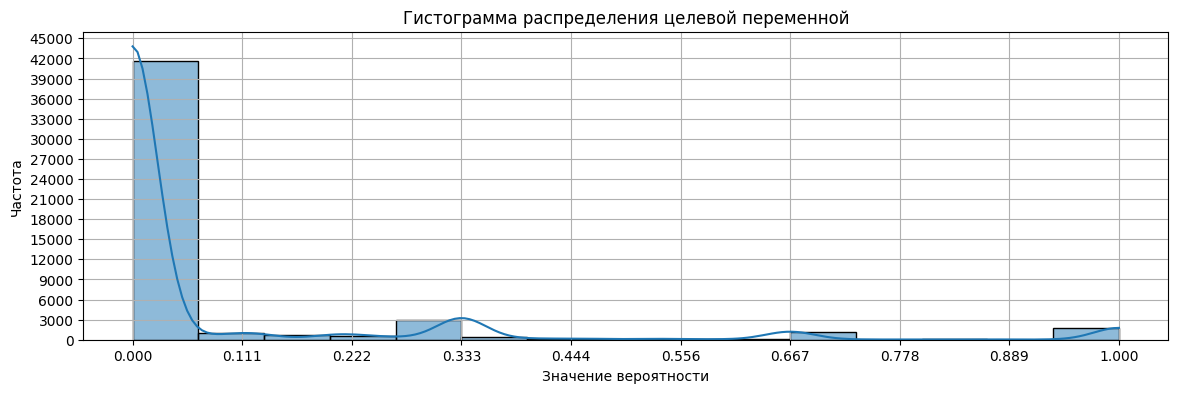

In [ ]:
fig, ax = plt.subplots(figsize=(14, 4))
_ = sns.histplot(data=train_data['target_prob'], kde=True, bins=15, ax=ax)
_ = ax.grid(True)
_ = ax.set_xticks(np.linspace(0, 1, 10))
_ = ax.set_yticks(range(0, 46000, 3000))
_ = ax.set_title('Гистограмма распределения целевой переменной')
_ = ax.set_xlabel('Значение вероятности')
_ = ax.set_ylabel('Частота')

Распределение заметно скошено вправо, при этом наблюдаются некоторые всплески частот у значений `0.333` (особенно заметно), `0.667` (менее заметно) и `1.000` (вновь довольно заметно).

### Шаг 2.1 Создайте список слов которые, по вашему мнению, могут попадать под юридические ограничения

Поскольку юридические ограничения относятся к публикации фотографий с участием детей, то попробуем перечислить слова, относящиеся к детям. Перечислять будем не леммы, а словоформы, чтобы учесть возможность использования множественного числа:

In [ ]:
stoplist_words = {
    'child', 'childs', 'children', 'youngster', 'youngsters', 'boy', 'boys', 'girl', 'girls',
    'baby', 'babies', 'newborn', 'newborns', 'infant', 'infants', 'junior', 'juniors', 'kid',
    'kids', 'kiddie', 'youth', 'minor', 'minors', 'teen', 'teens', 'babe', 'babes'
}

### Шаг 2.2 Исключите из обучающего датасета пары, которые, исходя из подготовленного вами списка слов, могут попадать под юридические ограничения

In [ ]:
def is_bad_comment(query_text):
  words = set(query_text.lower().split())
  return 0 != len(words & stoplist_words)

train_data['is_bad_comment'] = train_data['query_text'].apply(is_bad_comment)

display(train_data.sample(5, random_state=3))

image                     query_id  \
47774    53043785_c468d6f931.jpg  2292406847_f366350600.jpg#2   
49888   909808296_23c427022d.jpg  3396157719_6807d52a81.jpg#2   
2840    160792599_6a7ec52516.jpg  3589367895_5d3729e3ea.jpg#2   
23357  2844641033_dab3715a99.jpg   979383193_0a542a059d.jpg#2   
23062  2830869109_c4e403eae6.jpg  1427391496_ea512cbe7f.jpg#2   

                                              query_text  expert_1  expert_2  \
47774                        A man rows his boat below .       NaN       NaN   
49888                       A dog gets on a trampoline .       NaN       NaN   
2840                     An Indian chief in full dress .       1.0       1.0   
23357  Six children , all with black hair , sit at a ...       NaN       NaN   
23062   A young boy holds onto a blue handle on a pier .       NaN       NaN   

       expert_3  portion  num_voted_relevant  num_voted_irrelevant  \
47774       NaN      0.0                 0.0                   3.0   
49888       NaN      0.0                 0.0                   3.0   
2840        1.0      NaN                 NaN                   NaN   
23357       NaN      0.0                 0.0                   3.0   
23062       NaN      0.0                 0.0                   3.0   

       target_prob  is_bad_comment  
47774          0.0           False  
49888          0.0           False  
2840           0.0           False  
23357          0.0            True  
23062          0.0            True

Сначала удалим изображения:

In [ ]:
removed_images_count = 0
bad_image_names = []

def remove_bad_image(row):
    global removed_images_count
    if row['is_bad_comment']:
        bad_image_name = row['query_id'][0:-2]
        bad_image_names.append(bad_image_name)
        bad_image_path = Path(f'{data_dir}/train_images/{bad_image_name}')
        if bad_image_path.exists():
            bad_image_path.unlink(missing_ok=False)
            removed_images_count += 1
    return row

_ = train_data.apply(remove_bad_image, axis=1)

print(f'Итого удалено {removed_images_count} изображений.')

Итого удалено 286 изображений.


Теперь удалим строки в таблице:

In [ ]:
num_rows_before = train_data.shape[0]

# Удаляем строки, для которых был выставлен флаг 'is_bad_comment' (это строки с запрещённым описением)
train_data.drop(train_data.query('is_bad_comment == True').index, inplace=True)
train_data.drop('is_bad_comment', axis=1, inplace=True)

# Удаляем строки, для которых картинка ('image') является запрещённой
train_data.drop(train_data.query('image in @bad_image_names').index, inplace=True)

num_rows_after = train_data.shape[0]

print(f'Число строк до исключения запрещённого    : {num_rows_before}')
print(f'Число строк после исключения запрещённого : {num_rows_after}')
removed_portion = (num_rows_before - num_rows_after) / num_rows_before
print(f'Удалено {removed_portion:.2%} строк')

Число строк до исключения запрещённого    : 50480
Число строк после исключения запрещённого : 29326
Удалено 41.91% строк


### Шаг 2.3 Сделайте векторизацию текстового описания (TF-IDF или BERT или word2vec)

Попробуем использовать модель BERT:

In [ ]:
BERT_MODEL = BertModel.from_pretrained('bert-base-uncased').to(device)
TOKENIZER = BertTokenizer.from_pretrained('bert-base-uncased')

def create_text_embeddings(texts_series, quiet=False):
  tokenized = texts_series.apply(lambda x: TOKENIZER.encode(x, add_special_tokens=True))

  max_len = 0
  for i in tokenized.values:
      if len(i) > max_len:
          max_len = len(i)

  padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

  attention_mask = np.where(padded != 0, 1, 0)

  batch_size = 100
  text_embeddings = None
  iterations_count = (padded.shape[0] // batch_size) + 1
  for i in notebook.tqdm(range(iterations_count)):
          batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]).to(device)
          attention_mask_batch = torch.LongTensor(
              attention_mask[batch_size*i:batch_size*(i+1)]).to(device)
          
          with torch.no_grad():
              batch_embeddings = BERT_MODEL(batch, attention_mask=attention_mask_batch)

          text_embedding = batch_embeddings[0][:, 0, :]
          if i == 0:
            text_embeddings = text_embedding
          else:
            text_embeddings = torch.vstack([text_embeddings, text_embedding])

  text_vectors = text_embeddings.cpu().numpy()

  if not quiet:
    print(f'Создан тензор для погружений текстовых описаний размером {text_vectors.shape}')
  return text_vectors

train_text_embeddings = create_text_embeddings(train_data['query_text'])

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/294 [00:00<?, ?it/s]

Создан тензор для погружений текстовых описаний размером (29326, 768)


### Шаг 2.4 Сделайте векторизацию изображений с использованием модели ResNet50 из библиотеки PyTorch

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

In [ ]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform=None):
        self.transform = transform
        self.img_paths = sorted(os.path.join(root, x) for x in os.listdir(root) if x.endswith('.jpg'))

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        sample = torchvision.datasets.folder.default_loader(img_path)
        if self.transform is not None:
            sample = self.transform(sample)
        return img_path, sample

def create_data_loader(dir):
  transformations = torchvision.transforms.Compose([
    torchvision.transforms.Resize((256, 256)),
    torchvision.transforms.ToTensor()              
  ])

  image_dataset = ImageDataset(root=dir, transform=transformations)
  data_loader = torch.utils.data.DataLoader(image_dataset, batch_size=8, shuffle=False)

  print(f'Создан DataLoader на {len(image_dataset)} изображений из пути {dir}')

  return data_loader

In [ ]:
class ImageEmbeddingsInfo():
  def __init__(self):
      self.image_embeddings = None
      self.image_files = []
      self.image_to_embedding_index = {}

  def copy_embeddings_hook(self, module, input, output):
    output = output[:, :, 0, 0]
    image_embedding = output
    if self.image_embeddings is None:
      self.image_embeddings = image_embedding.detach().cpu().numpy()
    else:
      self.image_embeddings = np.vstack([self.image_embeddings, image_embedding.detach().cpu().numpy()])

  def get_embedding_by_filename(self, filename):
    index = self.image_to_embedding_index[filename]
    return self.image_embeddings[index]


class ImageEmbeddingsCreator():
    def __init__(self):
      self.resnet = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT').to(device)

    def create_image_embeddings(self, loader):
      result = ImageEmbeddingsInfo()

      _ = self.resnet._modules.get('avgpool').register_forward_hook(result.copy_embeddings_hook)
      
      self.resnet.eval()
      for i, data in enumerate(notebook.tqdm(loader)):
        image_paths = data[0]
        images = data[1]
        images = images.to(device)
        _ = self.resnet(images)
        result.image_files += image_paths
        size = len(result.image_to_embedding_index) - 1
        result.image_to_embedding_index.update({Path(k).name: (size := size + 1) for k in image_paths})

      print(f'Создан тензор для погружений картинок размером {result.image_embeddings.shape}')
      return result

In [ ]:
train_data_loader = create_data_loader(f'{data_dir}/train_images')

iec = ImageEmbeddingsCreator()
train_image_embeddings_info = iec.create_image_embeddings(train_data_loader)

emb = train_image_embeddings_info.get_embedding_by_filename('3673165148_67f217064f.jpg')
print(f'Размер погружения для пробной картинки: {emb.shape}')

Создан DataLoader на 714 изображений из пути ./to_upload/train_images


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 81.8MB/s]


  0%|          | 0/90 [00:00<?, ?it/s]

Создан тензор для погружений картинок размером (714, 512)
Размер погружения для пробной картинки: (512,)


### Шаг 2.5 Объедините векторы изображений и векторы текстов с целевой переменной. Дайте описание получившихся пар векторов с точки зрения их размерностей

In [ ]:
print(train_text_embeddings.shape)
print(train_image_embeddings_info.image_embeddings.shape)
print(train_data.shape)

display(train_data.tail())

(29326, 768)
(714, 512)
(29326, 10)


image                     query_id  \
50471  2869491449_1041485a6b.jpg  2869491449_1041485a6b.jpg#2   
50472  3452127051_fa54a902b3.jpg  3452127051_fa54a902b3.jpg#2   
50475  1082379191_ec1e53f996.jpg  1082379191_ec1e53f996.jpg#2   
50476   410453140_5401bf659a.jpg   410453140_5401bf659a.jpg#2   
50477  3200120942_59cfbb3437.jpg  3200120942_59cfbb3437.jpg#2   

                                              query_text  expert_1  expert_2  \
50471                           two dogs play together .       NaN       NaN   
50472  A dark dog is competing in a dog show competit...       NaN       NaN   
50475              A man and a woman sitting on a dock .       NaN       NaN   
50476  A man stands at the entrance of Yerba Buena Ce...       NaN       NaN   
50477  One person is on a ski lift while another snow...       NaN       NaN   

       expert_3  portion  num_voted_relevant  num_voted_irrelevant  \
50471       NaN      NaN                 NaN                   NaN   
50472       NaN      NaN                 NaN                   NaN   
50475       NaN      NaN                 NaN                   NaN   
50476       NaN      NaN                 NaN                   NaN   
50477       NaN      NaN                 NaN                   NaN   

       target_prob  
50471          1.0  
50472          1.0  
50475          1.0  
50476          1.0  
50477          1.0

In [ ]:
td = train_data.copy()
excess_cols = ['query_id', 'expert_1', 'expert_2', 'expert_3', 'portion', 'num_voted_relevant', 'num_voted_irrelevant']
td.drop(excess_cols, axis=1, inplace=True)

td = td.values
td = np.hstack([td, train_text_embeddings])
td = np.delete(td, obj=1, axis=1) # удаляем 1-ый столбец: 'query_text'
print(td.shape)
print(td[0:2, :])

(29326, 770)
[['1056338697_4f7d7ce270.jpg' 0.1111111111111111 0.225944384932518 ...
  -0.3192075192928314 0.43000924587249756 0.24305516481399536]
 ['3187395715_f2940c2b72.jpg' 0.2222222222222222 0.225944384932518 ...
  -0.3192075192928314 0.43000924587249756 0.24305516481399536]]


In [ ]:
image_col = td[:, 0]
image_col_embs = []                                                              
for image_filename in image_col:
  image_emb = train_image_embeddings_info.get_embedding_by_filename(image_filename)
  image_col_embs.append(image_emb) 

image_col_embs = np.vstack(image_col_embs)
print(image_col_embs.shape)

(29326, 512)


In [ ]:
Xy = np.hstack([td, image_col_embs])
print(Xy.shape)
print(Xy)

(29326, 1282)
[['1056338697_4f7d7ce270.jpg' 0.1111111111111111 0.225944384932518 ...
  2.7226836681365967 0.4182620644569397 0.4258924722671509]
 ['3187395715_f2940c2b72.jpg' 0.2222222222222222 0.225944384932518 ...
  4.123006820678711 0.6993743181228638 2.0905556678771973]
 ['463978865_c87c6ca84c.jpg' 0.19999999999999998 0.225944384932518 ...
  3.53953218460083 0.5399303436279297 0.24138903617858887]
 ...
 ['1082379191_ec1e53f996.jpg' 1.0 -0.27396777272224426 ...
  2.233218193054199 0.7491208910942078 0.5104942917823792]
 ['410453140_5401bf659a.jpg' 1.0 0.1626461297273636 ...
  3.8379642963409424 0.24828371405601501 0.39189767837524414]
 ['3200120942_59cfbb3437.jpg' 1.0 -0.4580276310443878 ...
  0.37676477432250977 0.1717345416545868 0.5111360549926758]]


#### Промежуточный вывод:

Полученный в результате набор данных содержит `29326` пар из картинки и текстового описания.

Размерность признаков равна `1282`, из которых `1280` приходится на сами признаки (`512` для погружения изображений и `768` для погружения тектовых описаний).

## Шаг 3. Обучите модель

Для обучения разделите датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки. Для того чтобы учесть изображения при разбиении, можно воспользоваться классом `GroupShuffleSplit` из библиотеки `sklearn.model_selection`.

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции `7:3` так, что строки с одинаковым значением `'group_column'` будут содержаться либо в тестовом, либо в тренировочном датасете:

```python
from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]
```

Какую модель использовать — выберите самостоятельно. Также вам предстоит выбрать метрику качества либо реализовать свою.

### Шаг 3.1 Разделите датасет на тренировочную и тестовую выборки

In [ ]:
def get_train_test_sets_from_indices(xy, train_indices, test_indices, quiet=True):
  xy_train = xy[train_indices, :]
  xy_test = xy[test_indices, :]

  # Удаляем первый стобец - это целевая переменная ('target_prob')
  x_train = np.delete(xy_train, obj=0, axis=1).astype('float64')
  x_test = np.delete(xy_test, obj=0, axis=1).astype('float64')

  y_train = xy_train[:, 0].astype('float64')
  y_test = xy_test[:, 0].astype('float64')

  x_train = torch.FloatTensor(x_train).to(device)
  x_test = torch.FloatTensor(x_test).to(device)
  y_train = torch.FloatTensor(y_train.reshape(-1, 1)).to(device)
  y_test = torch.FloatTensor(y_test.reshape(-1, 1)).to(device)

  if not quiet:
    print(f'x_train.shape={x_train.shape}')
    print(f'x_test.shape={x_test.shape}')
    print(f'y_train.shape={y_train.shape}')
    print(f'y_test.shape={y_test.shape}')

  return x_train, x_test, y_train, y_test

In [ ]:
Xy_with_image = Xy

images_all = Xy_with_image[:, 0]

# Удаляем первый стобец - имя изображения ('image')
Xy_no_image = np.delete(Xy_with_image, obj=0, axis=1)

GSS_TRAIN_TEST = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
GSS_TRAIN_TEST_SPLIT = GSS_TRAIN_TEST.split(X=Xy_no_image[:, :], y=Xy_no_image[:, 0], groups=images_all)
train_idx, test_idx = next(GSS_TRAIN_TEST_SPLIT)

X_train, X_test, y_train, y_test = get_train_test_sets_from_indices(Xy_no_image, train_idx, test_idx, quiet=False)

images_train = Xy_with_image[train_idx, 0]
Xy_no_image_train = Xy_no_image[train_idx, :]

GSS_CV = GroupShuffleSplit(n_splits=3, train_size=.7, random_state=42)
GSS_CV_SPLIT = GSS_CV.split(X=Xy_no_image_train[:, :], y=Xy_no_image_train[:, 0], groups=images_train)

print('-' * 50)

for cv_train_idx, cv_test_idx in GSS_CV_SPLIT:
  X_train_fold, X_test_fold, y_train_fold, y_test_fold =\
    get_train_test_sets_from_indices(Xy_no_image_train, cv_train_idx, cv_test_idx, quiet=False)

  print('-' * 10)

x_train.shape=torch.Size([20495, 1280])
x_test.shape=torch.Size([8831, 1280])
y_train.shape=torch.Size([20495, 1])
y_test.shape=torch.Size([8831, 1])
--------------------------------------------------
x_train.shape=torch.Size([14428, 1280])
x_test.shape=torch.Size([6067, 1280])
y_train.shape=torch.Size([14428, 1])
y_test.shape=torch.Size([6067, 1])
----------
x_train.shape=torch.Size([14232, 1280])
x_test.shape=torch.Size([6263, 1280])
y_train.shape=torch.Size([14232, 1])
y_test.shape=torch.Size([6263, 1])
----------
x_train.shape=torch.Size([13925, 1280])
x_test.shape=torch.Size([6570, 1280])
y_train.shape=torch.Size([13925, 1])
y_test.shape=torch.Size([6570, 1])
----------


### Шаг 3.2 Выберите метрику, по которой вы будете сравнивать точность различных моделей

Созданные модели будут возвращать нам схожесть между изображением и текстом в виде верояности, что некоторая пара изображение+описание представляют по сути одно и то же. В таком случае попробуем использовать в качестве метрики для сравнения различных моделей среднюю абсолютную ошибку (`MAE`) между предсказанной и истинной вероятностями.

### Шаг 3.3 Обучите несколько моделей, которые покажут близость двух векторов. Модели должна принимать на вход конкатенированный вектор, состоящий из векторов описания и изображений, и предсказывать итоговую оценку экспертов. Подберите их гиперпараметры
 В качестве моделей обязательно нужно рассмотреть:
##### - Линейную регрессию;
##### - Полносвязные нейронные сети.

#### Линейная регрессия

In [ ]:
mae_list = []

LINEAR_MODEL = Lasso(random_state=0, alpha=0.0001, max_iter=90000)

GSS_CV_SPLIT = GSS_CV.split(X=Xy_no_image_train[:, :], y=Xy_no_image_train[:, 0], groups=images_train)
for cv_train_idx, cv_test_idx in GSS_CV_SPLIT:
  X_train_fold, X_test_fold, y_train_fold, y_test_fold =\
    get_train_test_sets_from_indices(Xy_no_image_train, cv_train_idx, cv_test_idx)

  LINEAR_MODEL.fit(X_train_fold.cpu(), y_train_fold.cpu())
  y_pred_fold = LINEAR_MODEL.predict(X_test_fold.cpu()).reshape(-1, 1)
  
  y_test_fold = y_test_fold.cpu()

  mae_fold = mean_absolute_error(y_test_fold, y_pred_fold)
  mae_list.append(mae_fold)

print(f'MAE результаты кросс-валидации для линейной регрессии: {mae_list}')
print(f'Среднее MAE для линейной регрессии: {np.mean(mae_list)}')

MAE результаты кросс-валидации для линейной регрессии: [0.16304347094236674, 0.1661932028743032, 0.16745661482072663]
Среднее MAE для линейной регрессии: 0.16556442954579886


#### Полносвязная нейронная сеть

Создадим класс для полносвязной нейронной сети:

In [ ]:
class FeaturesProbDataset(Dataset):
  def __init__(self, features, target_prob):
    self.target_prob = target_prob
    self.features = features
    
  def __len__(self):
    return len(self.target_prob)

  def __getitem__(self, idx):
    target_prob = self.target_prob[idx]
    features = self.features[idx]
    sample = {"features": features, "target_prob": target_prob}
    return sample

dataset_train = FeaturesProbDataset(X_train, y_train)
dataset_test = FeaturesProbDataset(X_test, y_test)

train_dataloader = DataLoader(dataset_train, batch_size=64, shuffle=True, num_workers=0)
test_dataloader = DataLoader(dataset_test, batch_size=64, num_workers=0)

In [ ]:
class ImageTextSimNet(nn.Module):
  def __init__(self):
    super(ImageTextSimNet, self).__init__()

    self.layers = torch.nn.Sequential()

    self.layers.add_module('fc1', nn.Linear(in_features=X_train.shape[1], out_features=450, bias=True))
    self.layers.add_module('nb1', nn.BatchNorm1d(450, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
    self.layers.add_module('ac1', nn.ReLU())
    self.layers.add_module('dp1', nn.Dropout(p=0.3, inplace=False))

    self.layers.add_module('fc2', nn.Linear(in_features=450, out_features=150, bias=True))
    self.layers.add_module('nb2', nn.BatchNorm1d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
    self.layers.add_module('ac2', nn.ReLU())
    self.layers.add_module('dp2', nn.Dropout(p=0.3, inplace=False))

    self.layers.add_module('fc3', nn.Linear(in_features=150, out_features=50, bias=True))
    self.layers.add_module('bn3', nn.BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
    self.layers.add_module('ac3', nn.ReLU())
    self.layers.add_module('dp3', nn.Dropout(p=0.3, inplace=False))

    self.layers.add_module('final', nn.Linear(in_features=50, out_features=1))

    self.init_weights()

  def forward(self, x):
    return self.layers(x)

  def init_weights(self):
    for layer in self.layers:
      if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_normal_(layer.weight)

Опишем её функцию обучения:

In [ ]:
class CustomEarlyStopping():
  """
  Ранняя остановка, чтобы остановить тренировку, когда потеря не улучшается после определенной эпохи.
  """
  def __init__(self, patience=5, min_delta=0):
    """
    :param patience: сколько эпох ждать, прежде чем остановиться, когда потеря не улучшается
    :param min_delta: минимальная разница между loss/метриками, если улучшений нет, то остановим обучение
    """
    self.patience = patience
    self.min_delta = min_delta
    self.counter = 0
    self.best_loss = None
    self.early_stop = False

  def __call__(self, val_loss):
    if self.best_loss == None:
      self.best_loss = val_loss
    elif self.best_loss - val_loss > self.min_delta:
      self.best_loss = val_loss
      # reset counter if validation loss improves
      self.counter = 0
    elif self.best_loss - val_loss < self.min_delta:
      self.counter += 1
      print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
      if self.counter >= self.patience:
        print('INFO: Early stopping')
        self.early_stop = True

In [ ]:
def nn_train_evauate_valid(model, loss, optimizer, dataset_train, dataset_valid):
  epochs = 100
  train_loss = 0.

  early_stopping = CustomEarlyStopping(patience=4, min_delta=20)

  train_dataloader = DataLoader(dataset_train, batch_size=128, shuffle=True, num_workers=0)
  test_dataloader = DataLoader(dataset_test, batch_size=128, num_workers=0)

  for epoch in range(epochs):
    # Обучаем эпоху батчами

    model.train()

    for batch in train_dataloader:
      features_train = batch['features']
      label_train = batch['target_prob']
      optimizer.zero_grad()

      predictions = model.forward(features_train)
      loss_value = loss(predictions, label_train)
      train_loss += loss_value.item()

      loss_value.backward()
      optimizer.step()

    # Эпоха обучена

    train_mae = train_loss / (len(train_dataloader)*epochs)
    print(f'Результаты: train_mae={train_mae:.5f}, test_mae=-------, final_mae=-------, эпоха #{epoch}')

    if epoch % 5 != 0:
      # Учим следующую эпоху
      continue
    
    # Прогоняем на валидации
    
    model.eval()
    predicted_probs = []
    true_probs = []
    valid_loss = 0.
    with torch.no_grad():
      for batch in test_dataloader:
        features_test = batch['features']
        label_test = batch['target_prob']

        predictions = model.forward(features_test)
        loss_value = loss(predictions, label_test)
        valid_loss += loss_value

        predicted_probs.append(predictions)
        true_probs.append(label_test)

    predicted_probs = torch.cat(predicted_probs)
    true_probs = torch.cat(true_probs)

    test_mae = valid_loss / len(test_dataloader)
    final_mae = loss(true_probs, predicted_probs)

    print(f'Результаты: train_mae={train_mae:.5f}, test_mae={test_mae:.5f}, final_mae={final_mae:.5f}, эпоха #{epoch}')

    early_stopping(test_mae)
    if early_stopping.early_stop:
      print('Early Stopping!')
      return test_mae
    
  return None

In [ ]:
def nn_cross_validate(model, loss, optimizer):
  nn_mae_list = []

  GSS_CV_SPLIT = GSS_CV.split(X=Xy_no_image_train[:, :], y=Xy_no_image_train[:, 0], groups=images_train)
  fold_index = 0
  for cv_train_idx, cv_test_idx in GSS_CV_SPLIT:
    X_train_fold, X_test_fold, y_train_fold, y_test_fold =\
      get_train_test_sets_from_indices(Xy_no_image_train, cv_train_idx, cv_test_idx)

    dataset_train = FeaturesProbDataset(X_train_fold, y_train_fold)
    dataset_valid = FeaturesProbDataset(X_test_fold, y_test_fold)

    mae = nn_train_evauate_valid(image_text_sim_net, loss, optimizer, dataset_train, dataset_valid)
    nn_mae_list.append(mae.cpu().item())

    fold_index += 1
    print('=' * 80)
    print(f'Окончена обработка фолда #{fold_index}')
    print('=' * 80)

  print(f'MAE результаты кросс-валидации для нейронной сети: {nn_mae_list}')
  print(f'Среднее MAE для нейронной сети: {np.mean(nn_mae_list)}')

image_text_sim_net = ImageTextSimNet().to(device)
optimizer = torch.optim.Adam(image_text_sim_net.parameters(), lr=1e-2)

nn_cross_validate(image_text_sim_net, nn.L1Loss(), optimizer)

Результаты: train_mae=0.00176, test_mae=-------, final_mae=-------, эпоха #0
Результаты: train_mae=0.00176, test_mae=0.11002, final_mae=0.10998, эпоха #0
Результаты: train_mae=0.00288, test_mae=-------, final_mae=-------, эпоха #1
Результаты: train_mae=0.00398, test_mae=-------, final_mae=-------, эпоха #2
Результаты: train_mae=0.00507, test_mae=-------, final_mae=-------, эпоха #3
Результаты: train_mae=0.00616, test_mae=-------, final_mae=-------, эпоха #4
Результаты: train_mae=0.00724, test_mae=-------, final_mae=-------, эпоха #5
Результаты: train_mae=0.00724, test_mae=0.10754, final_mae=0.10750, эпоха #5
INFO: Early stopping counter 1 of 4
Результаты: train_mae=0.00832, test_mae=-------, final_mae=-------, эпоха #6
Результаты: train_mae=0.00941, test_mae=-------, final_mae=-------, эпоха #7
Результаты: train_mae=0.01049, test_mae=-------, final_mae=-------, эпоха #8
Результаты: train_mae=0.01157, test_mae=-------, final_mae=-------, эпоха #9
Результаты: train_mae=0.01266, test_mae=

На полной тренировочной выборке обучим линейную модель и модель градиентного бустинга, прогонимся на тестовой выборке, сохраним полученные значение `MAE`:

In [ ]:
LINEAR_MODEL.fit(X_train.cpu(), y_train.cpu().ravel())
y_pred_test = LINEAR_MODEL.predict(X_test.cpu())
linear_model_mae_test = mean_absolute_error(y_test.cpu().ravel(), y_pred_test)
print(f'Итоговое MAE на полной тестовой выборке для линейной модели: {linear_model_mae_test}')

Итоговое MAE на полной тестовой выборке для линейной модели: 0.16169067312862057


Прогоняем нейронную сеть на полном обучающем наборе:

In [ ]:
def nn_train(model, x, y, loss, optimizer):
  image_text_sim_net.to(device)

  dataset_train_full = FeaturesProbDataset(x, y)
  train_dataloader_full = DataLoader(dataset_train_full, batch_size=128, shuffle=True, num_workers=0)

  num_epochs = 50

  for epoch in range(num_epochs):
    for batch in train_dataloader_full:
      batch_X = batch['features'].to(device)
      batch_y = batch['target_prob'].to(device)

      optimizer.zero_grad()

      predictions = image_text_sim_net.forward(batch_X).flatten()
      train_loss = loss(predictions, batch_y.flatten())

      train_loss.backward()
      optimizer.step()

nn_train(image_text_sim_net, X_train, y_train, nn.L1Loss(), optimizer)

Прогоняем модель на тестовом наборе:

In [ ]:
def evaluate_nn(model, x, y, loss):
  model.eval()
  predicted_probs = []
  true_probs = []
  test_loss = 0.

  dataset_test_full = FeaturesProbDataset(x, y)
  test_dataloader_full = DataLoader(dataset_test_full, batch_size=128, num_workers=0)

  with torch.no_grad():
    for batch in test_dataloader_full:
      features_test = batch['features']
      label_test = batch['target_prob']

      predictions = model.forward(features_test)
      loss_value = loss(predictions, label_test)
      test_loss += loss_value

      predicted_probs.append(predictions)
      true_probs.append(label_test)

  predicted_probs = torch.cat(predicted_probs)
  true_probs = torch.cat(true_probs)

  test_mae = test_loss / len(test_dataloader)
  final_mae = loss(true_probs, predicted_probs)

  return final_mae

nn_mae_test = evaluate_nn(image_text_sim_net, X_test, y_test, nn.L1Loss())
print(f'Итоговое MAE на полной тестовой выборке для нейронной сети: {nn_mae_test}')

Итоговое MAE на полной тестовой выборке для нейронной сети: 0.10806194692850113


Выведем итоговую таблицу с полученными значениями `MAE` для всех опробованных моделей:

In [ ]:
pd.DataFrame({
    'Имя модели:': [
        'Линейная модель',
        'Полносвязная нейронная сеть'],
    'Значение MAE на тестовой выборке:': [
        f'{linear_model_mae_test:.5f}',
        f'{nn_mae_test:.5f}']
}).set_index('Имя модели:')

Значение MAE на тестовой выборке:
Имя модели:                                                  
Линейная модель                                       0.16169
Полносвязная нейронная сеть                           0.10806

## Шаг 4. Тестирование модели и демонстрация ее работы

Обучим нейронную сеть на совместной тренировочной и тестовой выборках:

In [ ]:
Xy_train_test = np.delete(Xy, obj=0, axis=1).astype('float64')
X_train_test = np.delete(Xy_train_test, obj=0, axis=1).astype('float64')

y_train_test = Xy_train_test[:, 0].astype('float64')

X_train_test = torch.FloatTensor(X_train_test).to(device)
y_train_test = torch.FloatTensor(y_train_test.reshape(-1, 1)).to(device)

image_text_sim_net = ImageTextSimNet().to(device)

nn_train(image_text_sim_net, X_train_test, y_train_test, nn.L1Loss(), optimizer)

### Шаг 4.1 Проведите тестирование лучшей модели на тестовых данных

Необходимо получить эмбеддинги для всех тестовых изображений из папки `test_images`, выбрать случайные 10 запросов из файла `test_queries.csv` и для каждого запроса вывести наиболее релевантное изображение, сравнив визуально качество поиска.

Сначала загрузим тестовые данные из файлов:

In [ ]:
test_df = pd.read_csv(f'{data_dir}/test_queries.csv', sep='|', usecols=['query_id', 'query_text', 'image'])

test_text_embeddings = create_text_embeddings(test_df['query_text'])
test_data_loader = create_data_loader(f'{data_dir}/test_images')
test_image_embeddings_info = iec.create_image_embeddings(test_data_loader)

print()
print(f'train_text_embeddings.shape={train_text_embeddings.shape}')
print(f'train_image_embeddings.shape={train_image_embeddings_info.image_embeddings.shape}')
print(f'train_image_files={len(train_image_embeddings_info.image_files)}')
print()
print(f'test_text_embeddings.shape={test_text_embeddings.shape}')
print(f'test_image_embeddings.shape={test_image_embeddings_info.image_embeddings.shape}')
print(f'test_image_files={len(test_image_embeddings_info.image_files)}')

  0%|          | 0/6 [00:00<?, ?it/s]

Создан тензор для погружений текстовых описаний размером (500, 768)
Создан DataLoader на 100 изображений из пути ./to_upload/test_images


  0%|          | 0/13 [00:00<?, ?it/s]

Создан тензор для погружений картинок размером (100, 512)

train_text_embeddings.shape=(29326, 768)
train_image_embeddings.shape=(814, 512)
train_image_files=714

test_text_embeddings.shape=(500, 768)
test_image_embeddings.shape=(100, 512)
test_image_files=100


Теперь возьмём сэмпл из `10` текстовых описаний, получим их погружения (эмбеддинги) и найдём наиболее релевантное изображение для каждого из запросов:

  0%|          | 0/1 [00:00<?, ?it/s]

Описание: A young boy jumps his bicycle on a tagged bike ramp .
Найдено лучшее соответствие, схожесть: -inf -> 0.02652
Найдено лучшее соответствие, схожесть: 0.02652 -> 0.09123
Найдено лучшее соответствие, схожесть: 0.09123 -> 0.40524
Найдено лучшее соответствие, схожесть: 0.40524 -> 0.53453
Найдено лучшее соответствие, схожесть: 0.53453 -> 0.95823
Найдено лучшее соответствие, схожесть: 0.95823 -> 1.07819
Найдено лучшее соответствие, схожесть: 1.07819 -> 1.62650
Найдено лучшее соответствие, схожесть: 1.62650 -> 1.65715
Итоговая лучшая схожесть: 1.65715
Итоговый лучший индекс: 382
Итоговое лучшее изображение: ./to_upload/train_images/317488612_70ac35493b.jpg


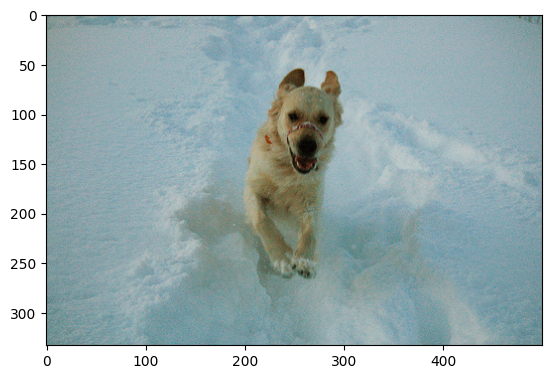

####################################################################################################
Описание: Two people sit on a wooden bench and face each other to talk .
Найдено лучшее соответствие, схожесть: -inf -> 0.38479
Найдено лучшее соответствие, схожесть: 0.38479 -> 0.76642
Найдено лучшее соответствие, схожесть: 0.76642 -> 1.15334
Найдено лучшее соответствие, схожесть: 1.15334 -> 1.19027
Найдено лучшее соответствие, схожесть: 1.19027 -> 1.66993
Найдено лучшее соответствие, схожесть: 1.66993 -> 1.81333
Найдено лучшее соответствие, схожесть: 1.81333 -> 1.90343
Итоговая лучшая схожесть: 1.90343
Итоговый лучший индекс: 464
Итоговое лучшее изображение: ./to_upload/train_images/3348385580_10b53391f9.jpg


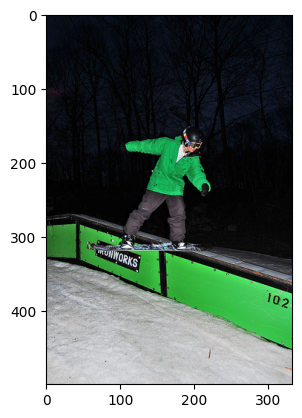

####################################################################################################
Описание: A woman wearing a red coat begins to take a picture .
Найдено лучшее соответствие, схожесть: -inf -> 0.51242
Найдено лучшее соответствие, схожесть: 0.51242 -> 0.55011
Найдено лучшее соответствие, схожесть: 0.55011 -> 0.62648
Найдено лучшее соответствие, схожесть: 0.62648 -> 0.74957
Найдено лучшее соответствие, схожесть: 0.74957 -> 0.98511
Найдено лучшее соответствие, схожесть: 0.98511 -> 1.05400
Найдено лучшее соответствие, схожесть: 1.05400 -> 1.11219
Найдено лучшее соответствие, схожесть: 1.11219 -> 1.54443
Найдено лучшее соответствие, схожесть: 1.54443 -> 1.68207
Найдено лучшее соответствие, схожесть: 1.68207 -> 1.70164
Итоговая лучшая схожесть: 1.70164
Итоговый лучший индекс: 614
Итоговое лучшее изображение: ./to_upload/train_images/3696698390_989f1488e7.jpg


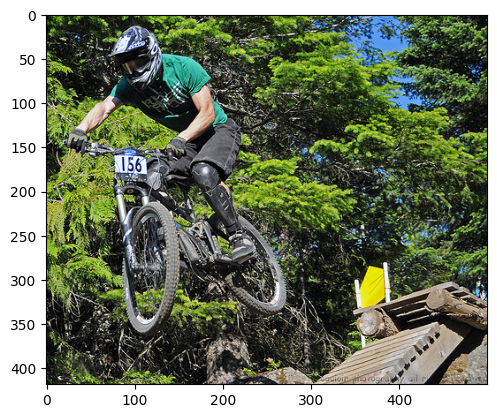

####################################################################################################
Описание: Men in a khaki-colored tent outside in a rundown area .
Найдено лучшее соответствие, схожесть: -inf -> 0.64308
Найдено лучшее соответствие, схожесть: 0.64308 -> 0.80040
Найдено лучшее соответствие, схожесть: 0.80040 -> 1.16620
Найдено лучшее соответствие, схожесть: 1.16620 -> 1.20663
Найдено лучшее соответствие, схожесть: 1.20663 -> 1.34912
Найдено лучшее соответствие, схожесть: 1.34912 -> 1.49362
Найдено лучшее соответствие, схожесть: 1.49362 -> 1.53540
Найдено лучшее соответствие, схожесть: 1.53540 -> 1.54001
Найдено лучшее соответствие, схожесть: 1.54001 -> 1.56381
Найдено лучшее соответствие, схожесть: 1.56381 -> 1.67778
Итоговая лучшая схожесть: 1.67778
Итоговый лучший индекс: 623
Итоговое лучшее изображение: ./to_upload/train_images/3720366614_dfa8fe1088.jpg


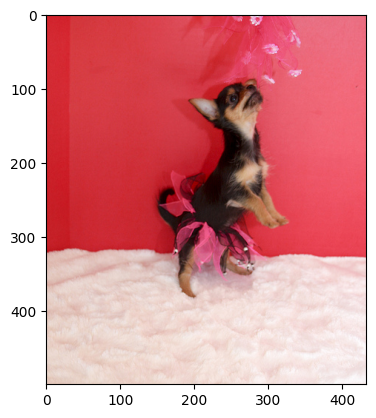

####################################################################################################
Описание: Men playing with a red ring out in the field .
Найдено лучшее соответствие, схожесть: -inf -> 0.83440
Найдено лучшее соответствие, схожесть: 0.83440 -> 1.01160
Найдено лучшее соответствие, схожесть: 1.01160 -> 1.03993
Найдено лучшее соответствие, схожесть: 1.03993 -> 1.04294
Найдено лучшее соответствие, схожесть: 1.04294 -> 1.05111
Найдено лучшее соответствие, схожесть: 1.05111 -> 1.12274
Найдено лучшее соответствие, схожесть: 1.12274 -> 1.21209
Найдено лучшее соответствие, схожесть: 1.21209 -> 1.52261
Найдено лучшее соответствие, схожесть: 1.52261 -> 1.61110
Найдено лучшее соответствие, схожесть: 1.61110 -> 1.90692
Итоговая лучшая схожесть: 1.90692
Итоговый лучший индекс: 623
Итоговое лучшее изображение: ./to_upload/train_images/3720366614_dfa8fe1088.jpg


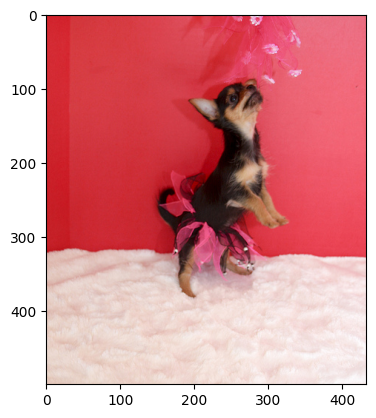

####################################################################################################
Описание: Three men on mountain bikes go over a sand hill .
Найдено лучшее соответствие, схожесть: -inf -> -0.10443
Найдено лучшее соответствие, схожесть: -0.10443 -> 0.39279
Найдено лучшее соответствие, схожесть: 0.39279 -> 0.62961
Найдено лучшее соответствие, схожесть: 0.62961 -> 0.90087
Найдено лучшее соответствие, схожесть: 0.90087 -> 1.01054
Найдено лучшее соответствие, схожесть: 1.01054 -> 1.23394
Итоговая лучшая схожесть: 1.23394
Итоговый лучший индекс: 302
Итоговое лучшее изображение: ./to_upload/train_images/2984174290_a915748d77.jpg


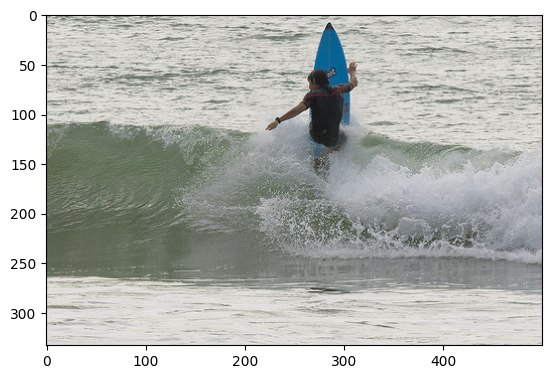

####################################################################################################
Описание: Children in swimming suits playing in water .
Найдено лучшее соответствие, схожесть: -inf -> 0.35993
Найдено лучшее соответствие, схожесть: 0.35993 -> 0.62657
Найдено лучшее соответствие, схожесть: 0.62657 -> 1.11560
Найдено лучшее соответствие, схожесть: 1.11560 -> 1.37913
Итоговая лучшая схожесть: 1.37913
Итоговый лучший индекс: 145
Итоговое лучшее изображение: ./to_upload/train_images/241345844_69e1c22464.jpg


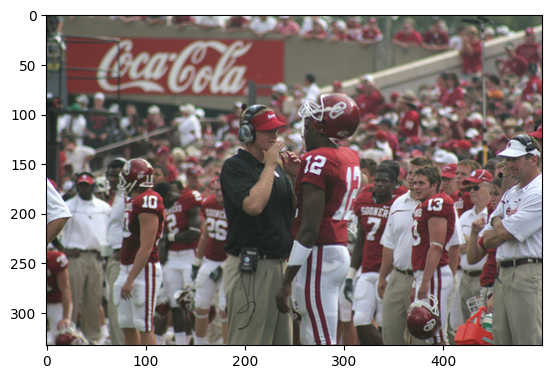

####################################################################################################
Описание: Two black dogs are tugging at an orange toy that is between them .
Найдено лучшее соответствие, схожесть: -inf -> 0.40092
Найдено лучшее соответствие, схожесть: 0.40092 -> 0.69357
Найдено лучшее соответствие, схожесть: 0.69357 -> 0.74225
Найдено лучшее соответствие, схожесть: 0.74225 -> 1.20752
Найдено лучшее соответствие, схожесть: 1.20752 -> 1.21654
Найдено лучшее соответствие, схожесть: 1.21654 -> 1.57625
Найдено лучшее соответствие, схожесть: 1.57625 -> 1.58182
Найдено лучшее соответствие, схожесть: 1.58182 -> 1.64092
Найдено лучшее соответствие, схожесть: 1.64092 -> 1.90488
Найдено лучшее соответствие, схожесть: 1.90488 -> 1.94849
Итоговая лучшая схожесть: 1.94849
Итоговый лучший индекс: 464
Итоговое лучшее изображение: ./to_upload/train_images/3348385580_10b53391f9.jpg


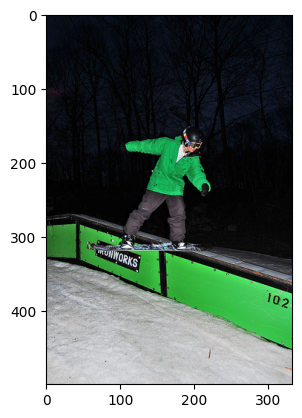

####################################################################################################
Описание: Two black dogs are fighting over a toy
Найдено лучшее соответствие, схожесть: -inf -> 0.02285
Найдено лучшее соответствие, схожесть: 0.02285 -> 0.58811
Найдено лучшее соответствие, схожесть: 0.58811 -> 0.63989
Найдено лучшее соответствие, схожесть: 0.63989 -> 0.89258
Найдено лучшее соответствие, схожесть: 0.89258 -> 1.11888
Найдено лучшее соответствие, схожесть: 1.11888 -> 1.76270
Итоговая лучшая схожесть: 1.76270
Итоговый лучший индекс: 95
Итоговое лучшее изображение: ./to_upload/train_images/2196316998_3b2d63f01f.jpg


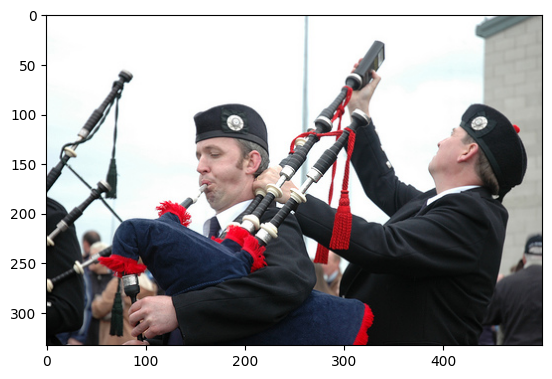

####################################################################################################
Описание: A group of six men stand in a circle playing instruments in a wooded parking lot .
Найдено лучшее соответствие, схожесть: -inf -> 0.59992
Найдено лучшее соответствие, схожесть: 0.59992 -> 0.93564
Найдено лучшее соответствие, схожесть: 0.93564 -> 1.07668
Найдено лучшее соответствие, схожесть: 1.07668 -> 1.08580
Найдено лучшее соответствие, схожесть: 1.08580 -> 1.12780
Найдено лучшее соответствие, схожесть: 1.12780 -> 1.15263
Найдено лучшее соответствие, схожесть: 1.15263 -> 1.27573
Найдено лучшее соответствие, схожесть: 1.27573 -> 1.30456
Найдено лучшее соответствие, схожесть: 1.30456 -> 1.49062
Найдено лучшее соответствие, схожесть: 1.49062 -> 1.81453
Найдено лучшее соответствие, схожесть: 1.81453 -> 1.84305
Найдено лучшее соответствие, схожесть: 1.84305 -> 1.95025
Найдено лучшее соответствие, схожесть: 1.95025 -> 2.00867
Итоговая лучшая схожесть: 2.00867
Итоговый лучший индек

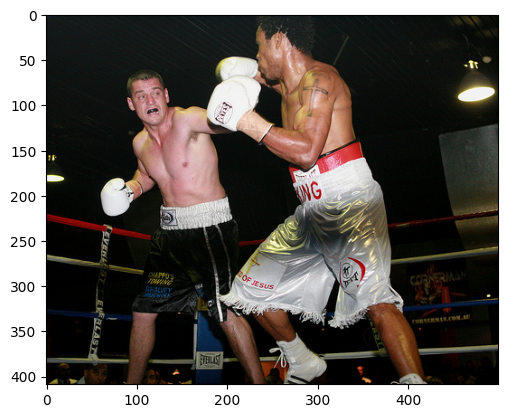

####################################################################################################


In [ ]:
sample_test_queries = test_df['query_text'].sample(10)
sample_test_text_embeddings = create_text_embeddings(sample_test_queries, quiet=True)

for query_index in range(sample_test_queries.shape[0]):
  print(f'Описание: {sample_test_queries.iloc[query_index]}')
  sample_test_text_embedding = sample_test_text_embeddings[query_index, :]

  champion_prob = -np.inf
  champion_index = 0
  for i in range(len(train_image_embeddings_info.image_files)):
    image = train_image_embeddings_info.image_files[i]
    train_image_embedding = train_image_embeddings_info.get_embedding_by_filename(Path(image).name)
    x = np.hstack([sample_test_text_embedding, train_image_embedding])
    x = x.reshape(1, -1) # приводим в вектор-строку

    image_text_sim_net.eval()
    pred_prob = image_text_sim_net.forward(torch.FloatTensor(x).to(device)).item()
        
    if pred_prob > champion_prob:
      print(f'Найдено лучшее соответствие, схожесть: {champion_prob:.5f} -> {pred_prob:.5f}')
      champion_prob = pred_prob
      champion_index = i

  print(f'Итоговая лучшая схожесть: {champion_prob:.5f}')
  print(f'Итоговый лучший индекс: {champion_index}')
  print(f'Итоговое лучшее изображение: {train_image_embeddings_info.image_files[champion_index]}')

  img = mpimg.imread(train_image_embeddings_info.image_files[champion_index])
  imgplot = plt.imshow(img)
  plt.show()
  print('#' * 100)

### Шаг 4.2 Напишите функцию, которая принимает на вход текстовое описание, делает его векторизацию и возвращает картинку с максимальным значением метрики. Если запрос ведёт на юридически вредный контент, функция должна выводить дисклеймер.

Напишем такую функцию:

In [ ]:
def find_most_similar_image(textual_description, quiet=True):
  print(f'Описание: {textual_description}')

  if is_bad_comment(textual_description):
    print('This image is unavailable in your country in compliance with local laws.')
    return None

  text_embedding = create_text_embeddings(pd.Series(textual_description), quiet=True)

  champion_prob = -np.inf
  champion_index = 0
  for train_image_index in range(len(train_image_embeddings_info.image_files)):
    train_image_file = train_image_embeddings_info.image_files[train_image_index]
    train_image_embedding = train_image_embeddings_info.image_embeddings[train_image_index].reshape(1, -1)
    x = np.hstack([text_embedding, train_image_embedding])
    x = x.reshape(1, -1) # приводим в вектор-строку
    
    image_text_sim_net.eval()
    pred_prob = image_text_sim_net.forward(torch.FloatTensor(x).to(device)).item()

    if pred_prob > champion_prob:
      if not quiet:
        print(f'Найдено лучшее соответствие, схожесть: {champion_prob:.5f} -> {pred_prob:.5f}')
      champion_prob = pred_prob
      champion_index = train_image_index

  if not quiet:
    print(f'Итоговая лучшая схожесть: {champion_prob:.5f}')
    print(f'Итоговый лучший индекс: {champion_index}')
    print(f'Итоговое лучшее изображение: {train_image_embeddings_info.image_files[champion_index]}')

  img = mpimg.imread(train_image_embeddings_info.image_files[champion_index])
  imgplot = plt.imshow(img)
  plt.show()

### Шаг 4.3 С помощью написанной вами функции протестируйте работу модели на нескольких текстовых описаниях: проверьте, какие картинки она выдает при различных текстовых запросах

Описание: Two young girls on a playground .
This image is unavailable in your country in compliance with local laws.
####################################################################################################
Описание: A white dog jumps to catch a blue ball in a living room .


  0%|          | 0/1 [00:00<?, ?it/s]

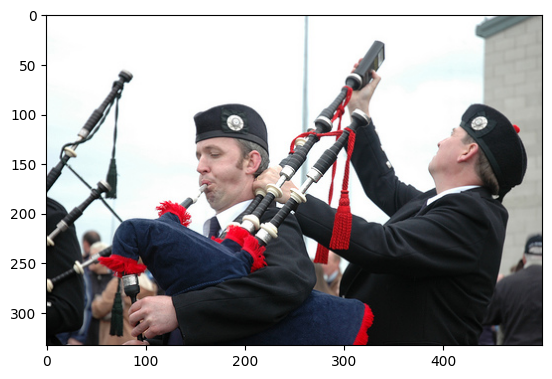

####################################################################################################
Описание: A dog runs through the deep snow .


  0%|          | 0/1 [00:00<?, ?it/s]

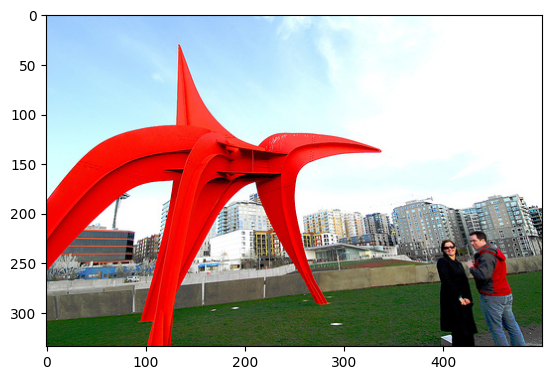

####################################################################################################
Описание: A man sleeps under a blanket on a city street


  0%|          | 0/1 [00:00<?, ?it/s]

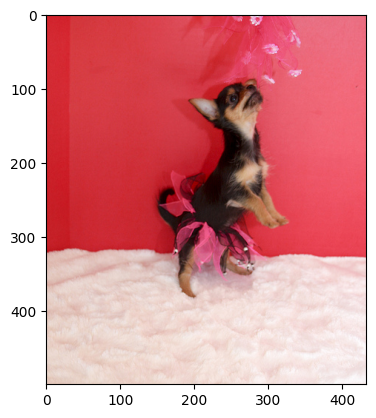

####################################################################################################
Описание: Man in mountains and rocks


  0%|          | 0/1 [00:00<?, ?it/s]

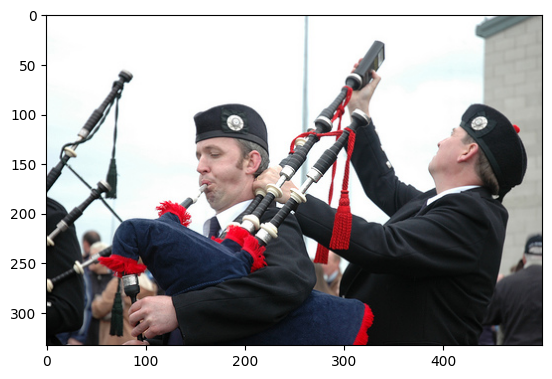

####################################################################################################
Описание: Man on bike bicycle cycle


  0%|          | 0/1 [00:00<?, ?it/s]

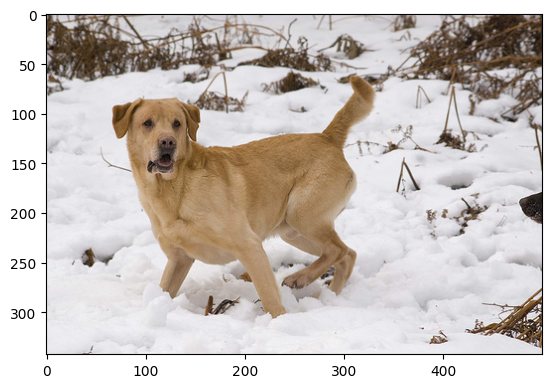

####################################################################################################
Описание: Man Sport


  0%|          | 0/1 [00:00<?, ?it/s]

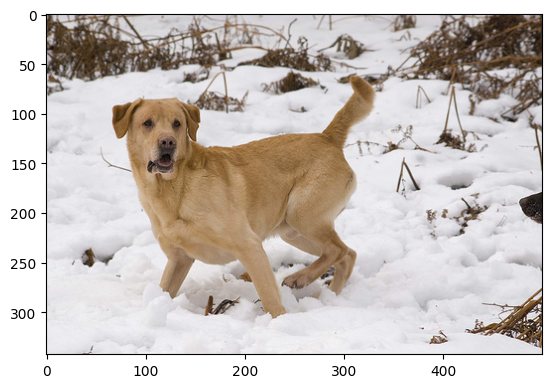

####################################################################################################
Описание: Basketball game


  0%|          | 0/1 [00:00<?, ?it/s]

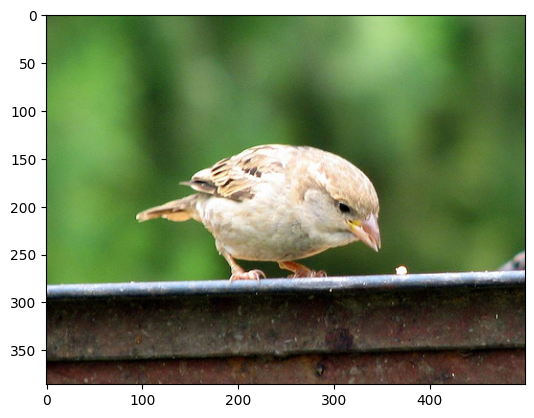

####################################################################################################
Описание: Ball game football players


  0%|          | 0/1 [00:00<?, ?it/s]

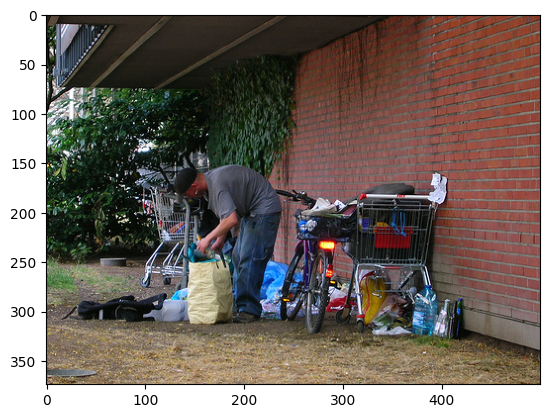

####################################################################################################
Описание: Bull carnival torero cowboy hat


  0%|          | 0/1 [00:00<?, ?it/s]

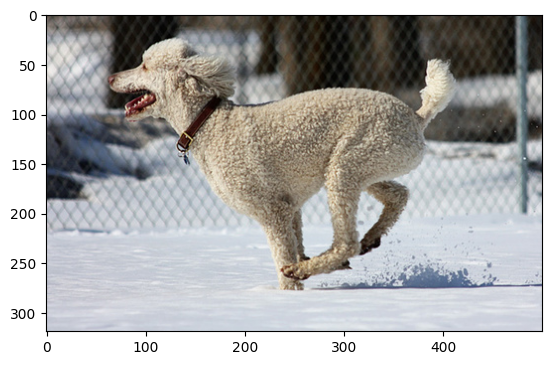

####################################################################################################


In [ ]:
manual_queries = [
  'Two young girls on a playground .', # запрос из тестовых данных

  'A white dog jumps to catch a blue ball in a living room .', # запрос из тренировочных данных
  'A dog runs through the deep snow .', # запрос из тренировочных данных
  'A man sleeps under a blanket on a city street', # запрос из тренировочных данных

  'Man in mountains and rocks',
  'Man on bike bicycle cycle',
  'Man Sport',
  'Basketball game',
  'Ball game football players',
  'Bull carnival torero cowboy hat'
]

for manual_query in manual_queries:
  find_most_similar_image(manual_query)
  print('#' * 100)

Удаляем за собой лишнее:

In [ ]:
!rm -rf dsplus_integrated_project_4.zip
!rm -rf __MACOSX
!rm -rf to_upload
!rm -rf bert_config.json
!rm -rf rubert_model.bin
!rm -rf vocab.txt

## Шаг 5. Сделайте общий вывод по работе

### Шаг 5.1 Опишите модель, которая лучше всего справляется с задачей сравнения сходства картинки и текста

Среди опробованных моделей наилучшее качество на тестовой выборке показала модель <u>нейронной сети</u>: `0.10806` по метрике `MAE`.

Более скромные результаты показала модель регуляризованной линейной регрессии Lasso — `0.16169` по `MAE`.

В итоге в качестве финальной модели можно выбрать модель на основе полносвязной нейронной сети.

### Шаг 5.2 Опишите, какие ошибки допускает модель во время поиска картинки по её текстовому описанию

Получившаяся модель на основе полносвязной нейронной сети допускает огромное множество ошибок, и её нельзя использовать для чего-то полезного.

### Шаг 5.3 Оцените, насколько проект по созданию сервиса поиска фотографий по текстовому описанию практически осуществим

Идея создания такого проекта выглядит осуществимой, но есть ощущение, что это потребует гораздо более большого количества данных.